In [1]:
# =========================
#         COMUNES
# =========================
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from IPython.display import display, Markdown

# Algoritmos y Métricas
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# Silenciar ruidos
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
warnings.filterwarnings("ignore")

# Rutas del Proyecto
try:
    from educational_ai_analytics.config import EMBEDDINGS_DATA_DIR, FEATURES_DATA_DIR, W_WINDOWS
    ROOT = Path(EMBEDDINGS_DATA_DIR)
    TARGET_PATH = Path(FEATURES_DATA_DIR) / "training" / "target.csv"
    WS_TO_PLOT = list(W_WINDOWS)
except ImportError:
    ROOT = Path("/workspace/TFM_education_ai_analytics/data/4_embeddings")
    TARGET_PATH = Path("/workspace/TFM_education_ai_analytics/data/3_features/training/target.csv")
    WS_TO_PLOT = [12, 18, 24]

# Parámetros Generales
SEED=42
SPLIT = "training"
EMB_TYPES = ["pca", "ae"]
MAX_POINTS_PLOT = 30000 
MAX_POINTS_METRICS = 30000
MAX_POINTS_ELBOW = 30000
MAX_POINTS_SILHOUETTE = 30000
K_RANGE = range(2, 16)
N_INIT = 10

# Estética y Mapeo Educativo (OULAD)
COLORS_MAP = {3: "#FFD700", 2: "#4A79B7", 1: "#C54443", 0: "#E39063"}
LABELS_MAP = {3: "Distinction", 2: "Pass", 1: "Fail", 0: "Withdrawn"}

def safe_read_csv(path: Path) -> pd.DataFrame:
    if not path.exists(): return pd.DataFrame()
    return pd.read_csv(path, index_col=0).replace([np.inf, -np.inf], np.nan).fillna(0.0)

# Carga global del Target para todas las celdas
df_target = pd.read_csv(TARGET_PATH, index_col=0)
global_success_rate = (df_target["final_result"] >= 2).mean() * 100

print(f"✅ Configuración Global lista. Éxito global: {global_success_rate:.1f}%")


#=========================================
# Configuracion particular de K-Means
#========================================
K=6
N_INIT_KM = 15

✅ Configuración Global lista. Éxito global: 47.1%


# 1. Clustering con K-means

⏳ Procesando PCA | Semana 10...
⏳ Procesando PCA | Semana 14...
⏳ Procesando PCA | Semana 18...
⏳ Procesando PCA | Semana 24...


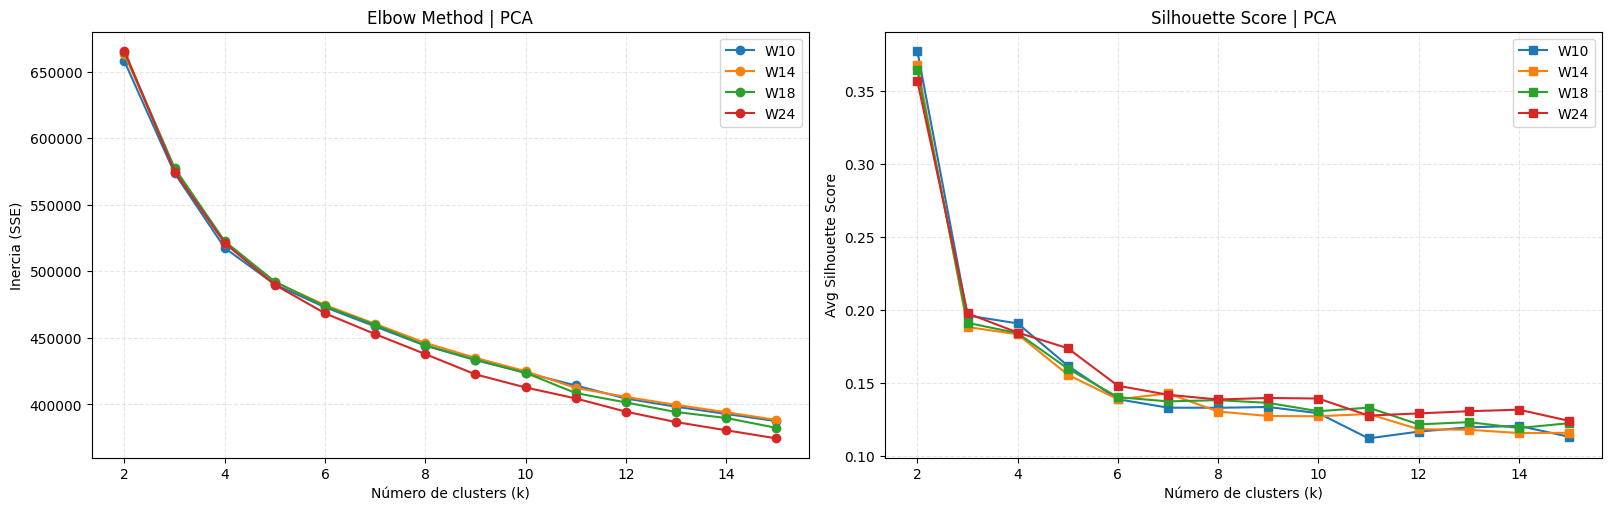

⏳ Procesando AE | Semana 10...
⏳ Procesando AE | Semana 14...
⏳ Procesando AE | Semana 18...
⏳ Procesando AE | Semana 24...


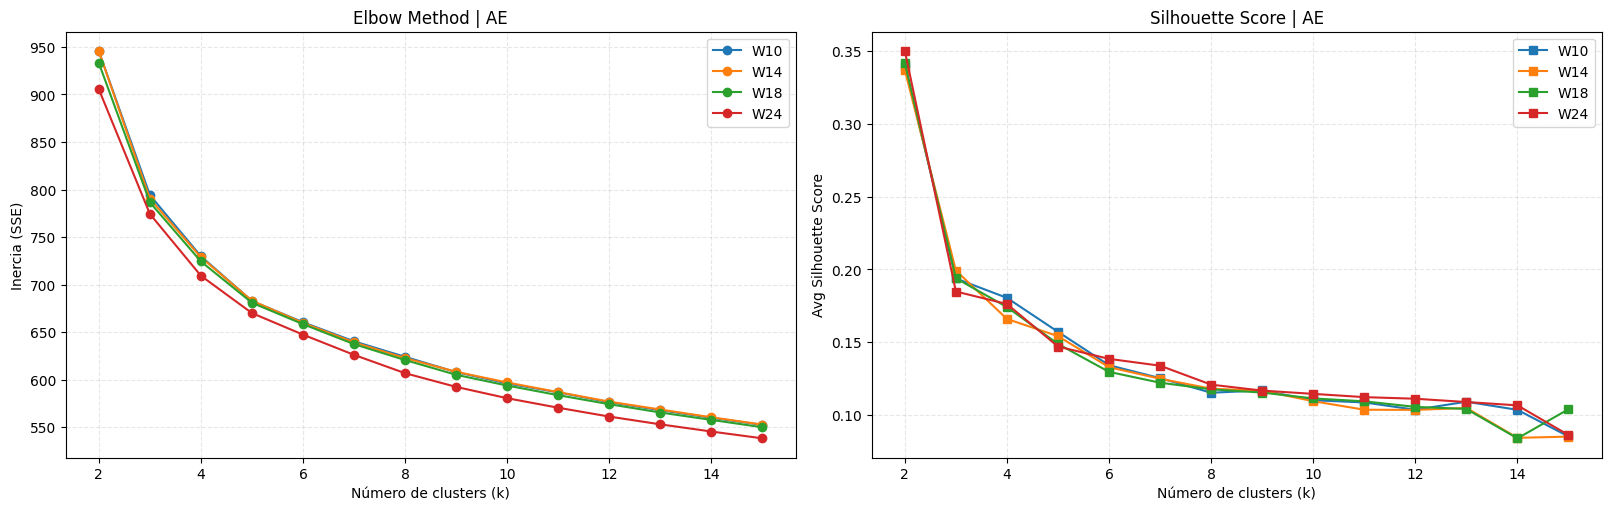

✅ Análisis de consistencia finalizado.


In [2]:
# 📈 Análisis de Codo (Elbow) y Silueta (Silhouette)

def safe_read_csv(path: Path) -> pd.DataFrame:
    """Lee un CSV gestionando valores nulos e infinitos."""
    if not path.exists(): return pd.DataFrame()
    return pd.read_csv(path, index_col=0).replace([np.inf, -np.inf], np.nan).fillna(0.0)

def file_for(split_dir: Path, W: int, emb_type: str) -> Path:
    """Genera la ruta al archivo de embedding según semana y técnica."""
    return split_dir / f"upto_w{W:02d}" / f"{emb_type}_latent.csv"

def compute_clustering_metrics(X: np.ndarray):
    """Calcula inercia y silueta para el rango de K definido globalmente."""
    inertias, silhouettes = [], []
    
    # Submuestreo específico para Silueta (O(N^2))
    X_sub = X
    if len(X) > MAX_POINTS_SILHOUETTE:
        idx = np.random.RandomState(SEED).choice(len(X), MAX_POINTS_SILHOUETTE, replace=False)
        X_sub = X[idx]
        
    for k in K_RANGE:
        km = KMeans(n_clusters=k, random_state=SEED, n_init=N_INIT)
        labels = km.fit_predict(X)
        inertias.append(km.inertia_)
        
        # Calculamos silueta sobre el subconjunto para mayor velocidad
        avg_s = silhouette_score(X_sub, km.predict(X_sub), random_state=SEED)
        silhouettes.append(avg_s)
        
    return inertias, silhouettes

# ---------- Ejecución ----------
split_dir = ROOT / SPLIT
available_types = [t for t in EMB_TYPES if any(file_for(split_dir, W, t).exists() for W in WS_TO_PLOT)]

for emb_type in available_types:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5), constrained_layout=True)
    
    for W in WS_TO_PLOT:
        path = file_for(split_dir, W, emb_type)
        df = safe_read_csv(path)
        if df.empty: continue
            
        # Submuestreo para el fit general si el dataset es masivo
        if len(df) > MAX_POINTS_ELBOW:
            df = df.sample(n=MAX_POINTS_ELBOW, random_state=SEED)
        
        X_data = df.values.astype(np.float32)
        print(f"⏳ Procesando {emb_type.upper()} | Semana {W}...")
        
        # Llamada a la función refactorizada
        vals_inert, vals_silh = compute_clustering_metrics(X_data)

        # Plotting
        ax1.plot(list(K_RANGE), vals_inert, marker="o", label=f"W{W}")
        ax2.plot(list(K_RANGE), vals_silh, marker="s", label=f"W{W}")

    # Estética de los gráficos
    ax1.set_title(f"Elbow Method | {emb_type.upper()}")
    ax1.set_xlabel("Número de clusters (k)"); ax1.set_ylabel("Inercia (SSE)")
    ax1.grid(True, alpha=0.3, linestyle='--'); ax1.legend()

    ax2.set_title(f"Silhouette Score | {emb_type.upper()}")
    ax2.set_xlabel("Número de clusters (k)"); ax2.set_ylabel("Avg Silhouette Score")
    ax2.grid(True, alpha=0.3, linestyle='--'); ax2.legend()
    
    plt.show()

print("✅ Análisis de consistencia finalizado.")

## Configuración particular K-MEans

### 🏁 Resultado Comparativo: PCA vs Autoencoder (K=6)

Métrica   Objetivo  \
0            Silueta (W24)  Maximizar   
1  Calinski-Harabasz (W24)  Maximizar   
2     Davies-Bouldin (W24)  Minimizar   

                                Descripción  Valor PCA   Valor AE Mejor  
0      Mide separación y cohesión (-1 a 1).     0.0601     0.1200  AE 🚀  
1  Ratio dispersión inter/intra (varianza).   881.0031  2794.3986  AE 🚀  
2       Similaridad media (menor es mejor).     3.0192     2.1713  AE 🚀

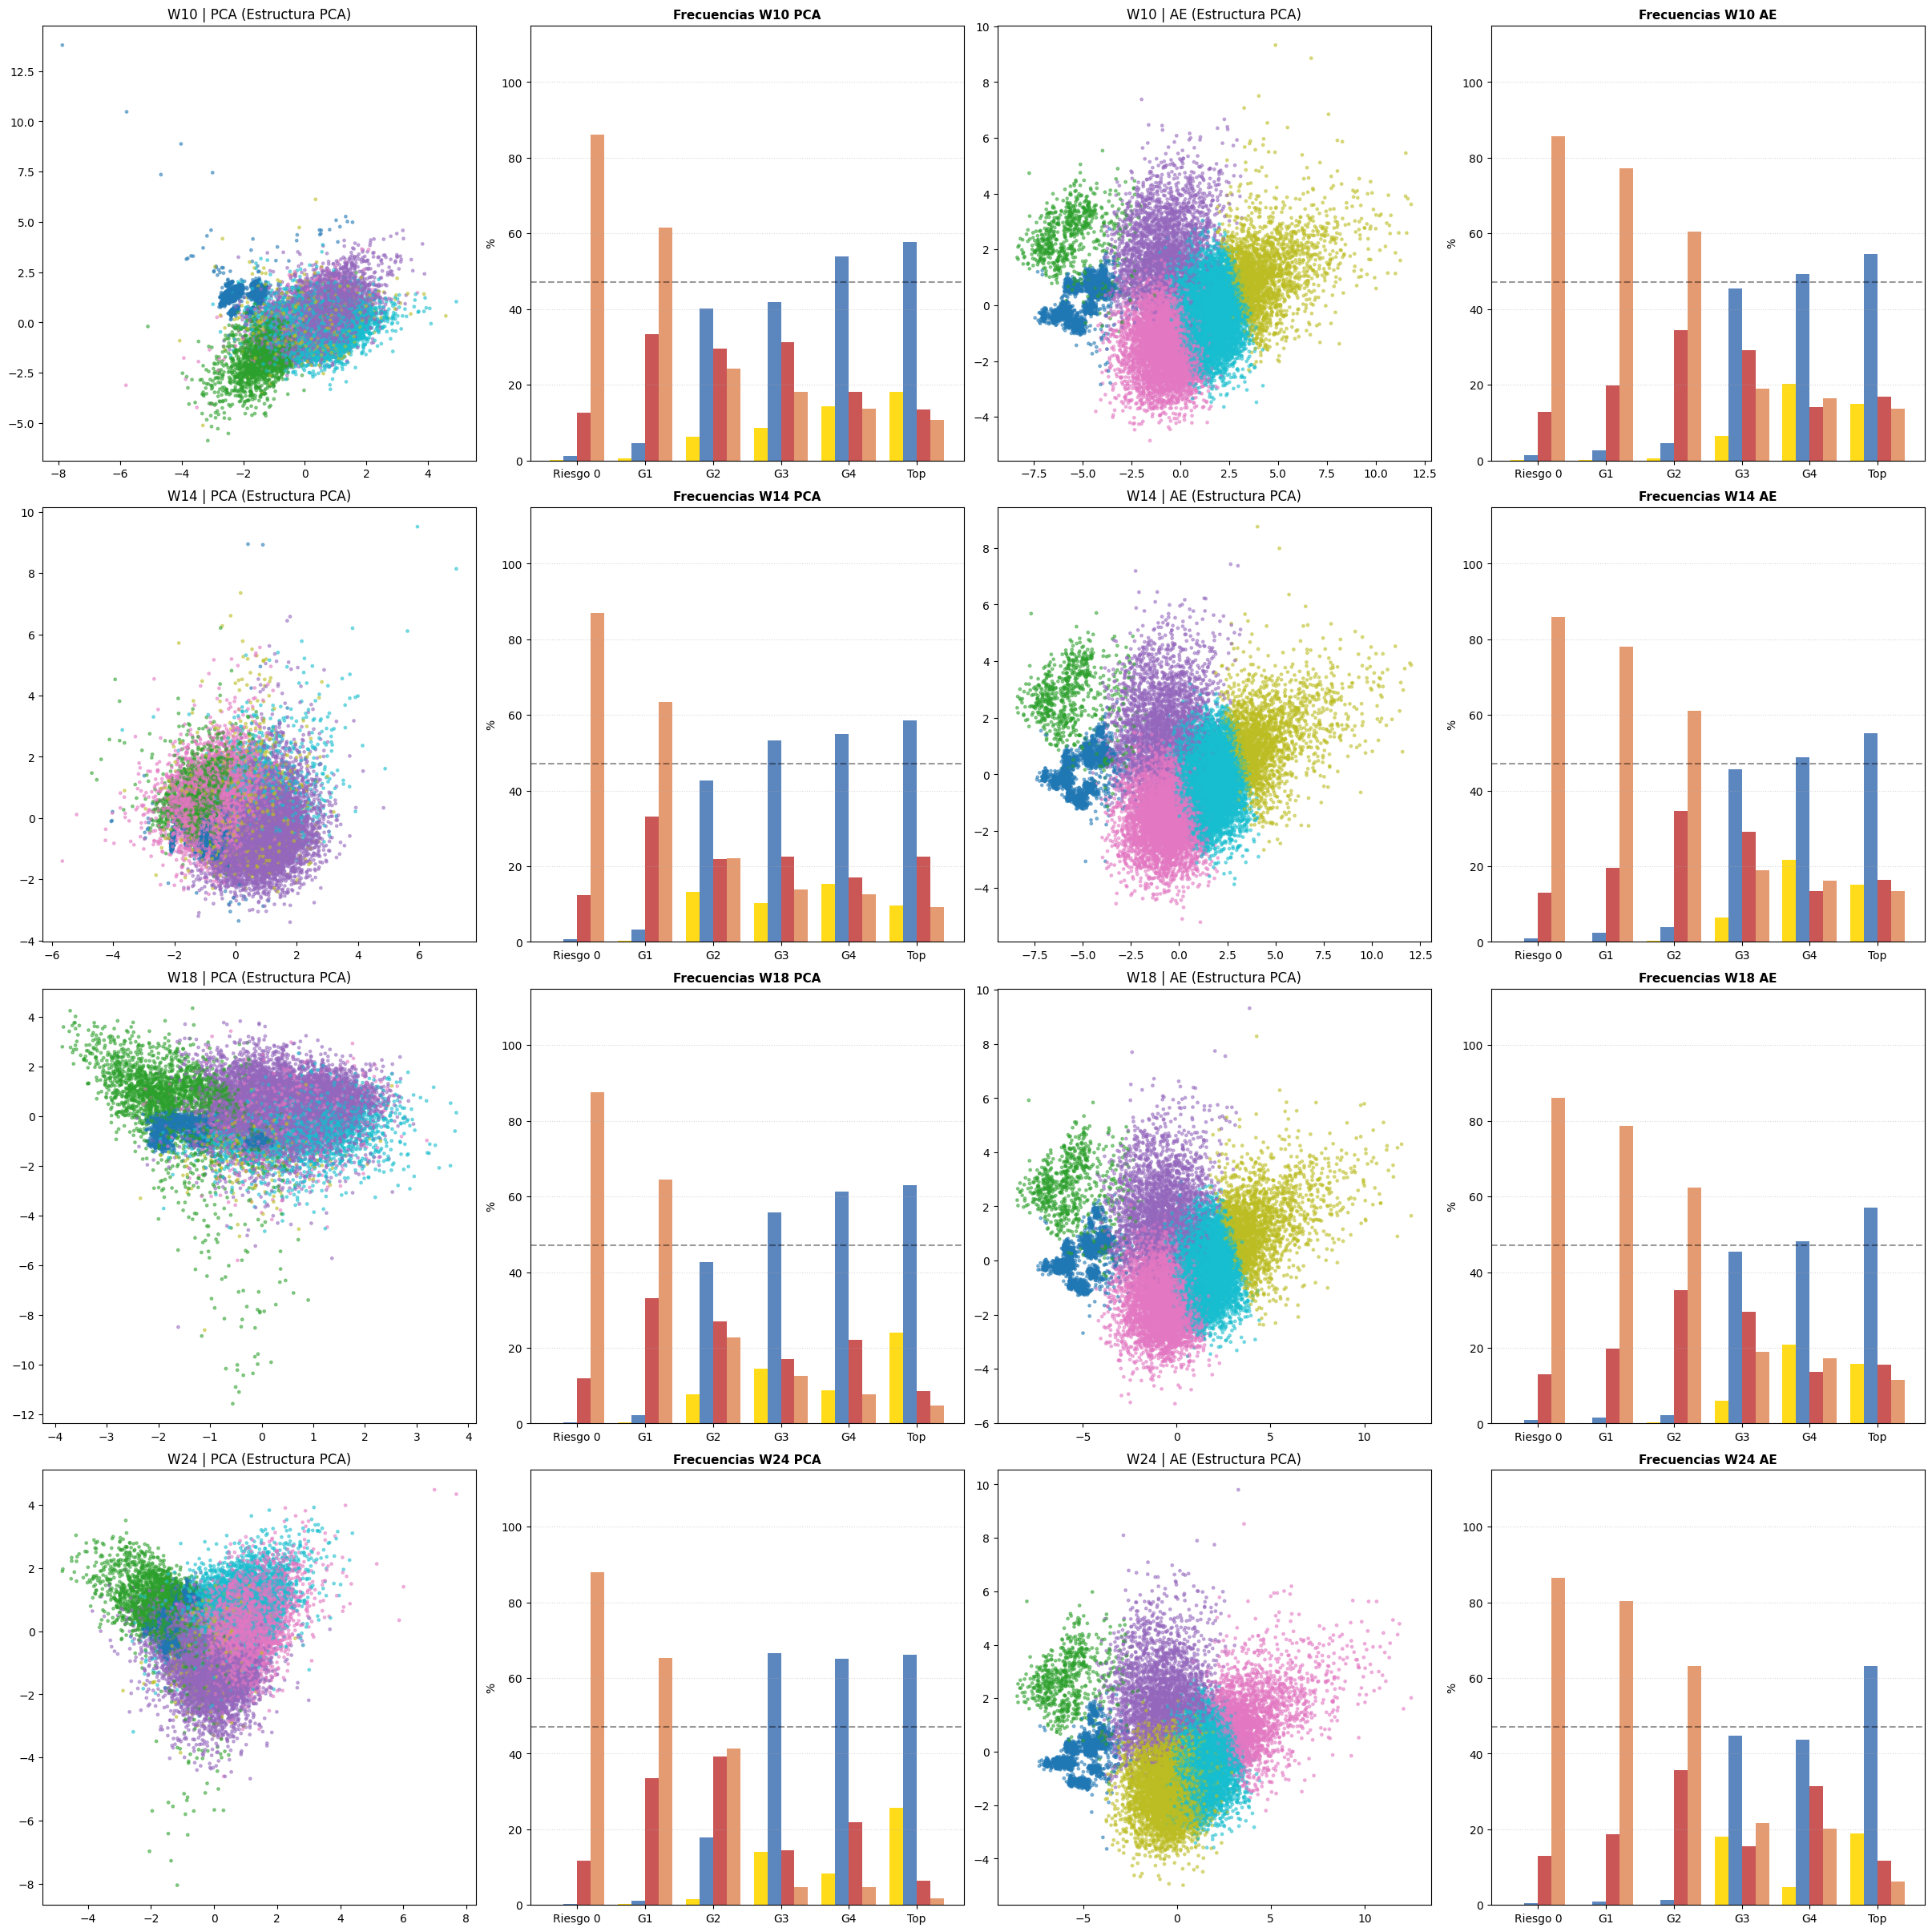

In [10]:
# ==========================================================
# 🎯 ANÁLISIS INTEGRADO: MÉTRICAS COMPARATIVAS Y DASHBOARD
# ==========================================================

# 1. Función Auxiliar para el Dashboard
def plot_educational_breakdown(ax, df_combined, title):
    """Genera la gráfica de barras con las etiquetas reales de OULAD."""
    counts = df_combined.groupby(["cluster", "final_result"]).size().unstack(fill_value=0)
    percentages = counts.div(counts.sum(axis=1), axis=0) * 100
    width = 0.2
    x = np.arange(len(percentages))
    # Iteramos sobre los resultados reales (3: Distinction, 2: Pass, 1: Fail, 0: Withdrawn)
    for i, res_val in enumerate([3, 2, 1, 0]):
        if res_val in percentages.columns:
            ax.bar(x + (i-1.5)*width, percentages[res_val], width, 
                   label=LABELS_MAP[res_val], color=COLORS_MAP[res_val], alpha=0.9)
    ax.axhline(global_success_rate, color="black", linestyle="--", alpha=0.4)
    ax.set_title(title, fontsize=11, fontweight='bold')
    ax.set_xticks(x)
    # Etiquetamos por riesgo (Riesgo 0 es el de mayor tasa de abandono)
    ax.set_xticklabels([f"Riesgo {i}" if i==0 else (f"Top" if i==K-1 else f"G{i}") for i in range(len(percentages))])
    ax.set_ylabel("%")
    ax.set_ylim(0, 115); ax.grid(axis='y', linestyle=':', alpha=0.5)

# 2. CÁLCULO DE MÉTRICAS (PCA vs AE)
metrics_data = []
results_storage = {} # Para usar en el dashboard sin repetir cálculos

for W in WS_TO_PLOT:
    for emb_t in EMB_TYPES:
        path = ROOT / SPLIT / f"upto_w{W:02d}" / f"{emb_t}_latent.csv"
        if not path.exists(): continue
        
        # Carga y homogeneización de índices
        df_l = safe_read_csv(path)
        idx = df_target.index.intersection(df_l.index)
        df_l = df_l.loc[idx]
        
        # Normalización y Clustering
        X = StandardScaler().fit_transform(df_l.values.astype(np.float32))
        km = KMeans(n_clusters=K, n_init=N_INIT_KM, random_state=SEED)
        clusters = km.fit_predict(X)
        
        # Guardar para el plot
        results_storage[(W, emb_t)] = (X, clusters, idx)
        
        # Calcular métricas
        metrics_data.append({
            "Semana": W, "Embedding": emb_t.upper(),
            "Silueta": silhouette_score(X, clusters, sample_size=10000, random_state=SEED),
            "Calinski-Harabasz": calinski_harabasz_score(X, clusters),
            "Davies-Bouldin": davies_bouldin_score(X, clusters)
        })

# 3. GENERACIÓN DE LA TABLA COMPARATIVA ESTRATÉGICA
# -----------------------------------------------
METRIC_DEFS = {
    'Silueta': ('Maximizar', 'Mide separación y cohesión (-1 a 1).'),
    'Calinski-Harabasz': ('Maximizar', 'Ratio dispersión inter/intra (varianza).'),
    'Davies-Bouldin': ('Minimizar', 'Similaridad media (menor es mejor).')
}

df_raw = pd.DataFrame(metrics_data)
final_comparison = []

# Escogemos la última semana analizada para la tabla principal
last_w = WS_TO_PLOT[-1]

for m_name, (objetivo, desc) in METRIC_DEFS.items():
    v_pca = df_raw[(df_raw['Semana']==last_w) & (df_raw['Embedding']=='PCA')][m_name].values[0]
    v_ae = df_raw[(df_raw['Semana']==last_w) & (df_raw['Embedding']=='AE')][m_name].values[0]
    
    ganador = "AE 🚀" if (objetivo=='Maximizar' and v_ae > v_pca) or (objetivo=='Minimizar' and v_ae < v_pca) else "PCA 📈"
    
    final_comparison.append({
        "Métrica": f"{m_name} (W{last_w})",
        "Objetivo": objetivo,
        "Descripción": desc,
        "Valor PCA": round(v_pca, 4),
        "Valor AE": round(v_ae, 4),
        "Mejor": ganador
    })

display(Markdown(f"### 🏁 Resultado Comparativo: PCA vs Autoencoder (K={K})"))
display(pd.DataFrame(final_comparison))

# 4. DASHBOARD VISUAL (PCA + FRECUENCIAS)
# ---------------------------------------
fig, axes = plt.subplots(len(WS_TO_PLOT), 4, figsize=(24, 6 * len(WS_TO_PLOT)), constrained_layout=True)

for i, W in enumerate(WS_TO_PLOT):
    for j, emb_t in enumerate(EMB_TYPES):
        if (W, emb_t) not in results_storage: continue
        X, raw_cl, idx = results_storage[(W, emb_t)]
        
        # Reordenar clusters por Riesgo (tasa de Withdrawn)
        tmp = pd.DataFrame({"cl": raw_cl, "res": df_target.loc[idx, "final_result"]})
        risk = tmp.groupby("cl")["res"].apply(lambda x: (x == 0).mean()).sort_values(ascending=False)
        rmap = {old: new for new, old in enumerate(risk.index)}
        order_cl = [rmap[c] for c in raw_cl]
        
        # Subplot 1: Vista Espacial (PCA)
        Z = PCA(n_components=2, random_state=SEED).fit_transform(X)
        axes[i, j*2].scatter(Z[:, 0], Z[:, 1], c=order_cl, s=6, cmap="tab10", alpha=0.5)
        axes[i, j*2].set_title(f"W{W} | {emb_t.upper()} (Estructura PCA)")
        
        # Subplot 2: Distribución de Resultados Reales
        plot_df = pd.DataFrame({"cluster": order_cl, "final_result": tmp["res"]})
        plot_educational_breakdown(axes[i, j*2+1], plot_df, f"Frecuencias W{W} {emb_t.upper()}")

plt.show()

🔍 ROOT: /workspace/TFM_education_ai_analytics/data/4_embeddings
🔍 SPLIT: training
🔍 Evaluando GMM (cov=diag, n_init=5, reg_covar=1e-06) para semanas: [10, 14, 18, 24]


⏳ Ajustando GMM para PCA | Semana W10 | n=22785 ...
⏳ Ajustando GMM para PCA | Semana W14 | n=22785 ...
⏳ Ajustando GMM para PCA | Semana W18 | n=22785 ...
⏳ Ajustando GMM para PCA | Semana W24 | n=22785 ...


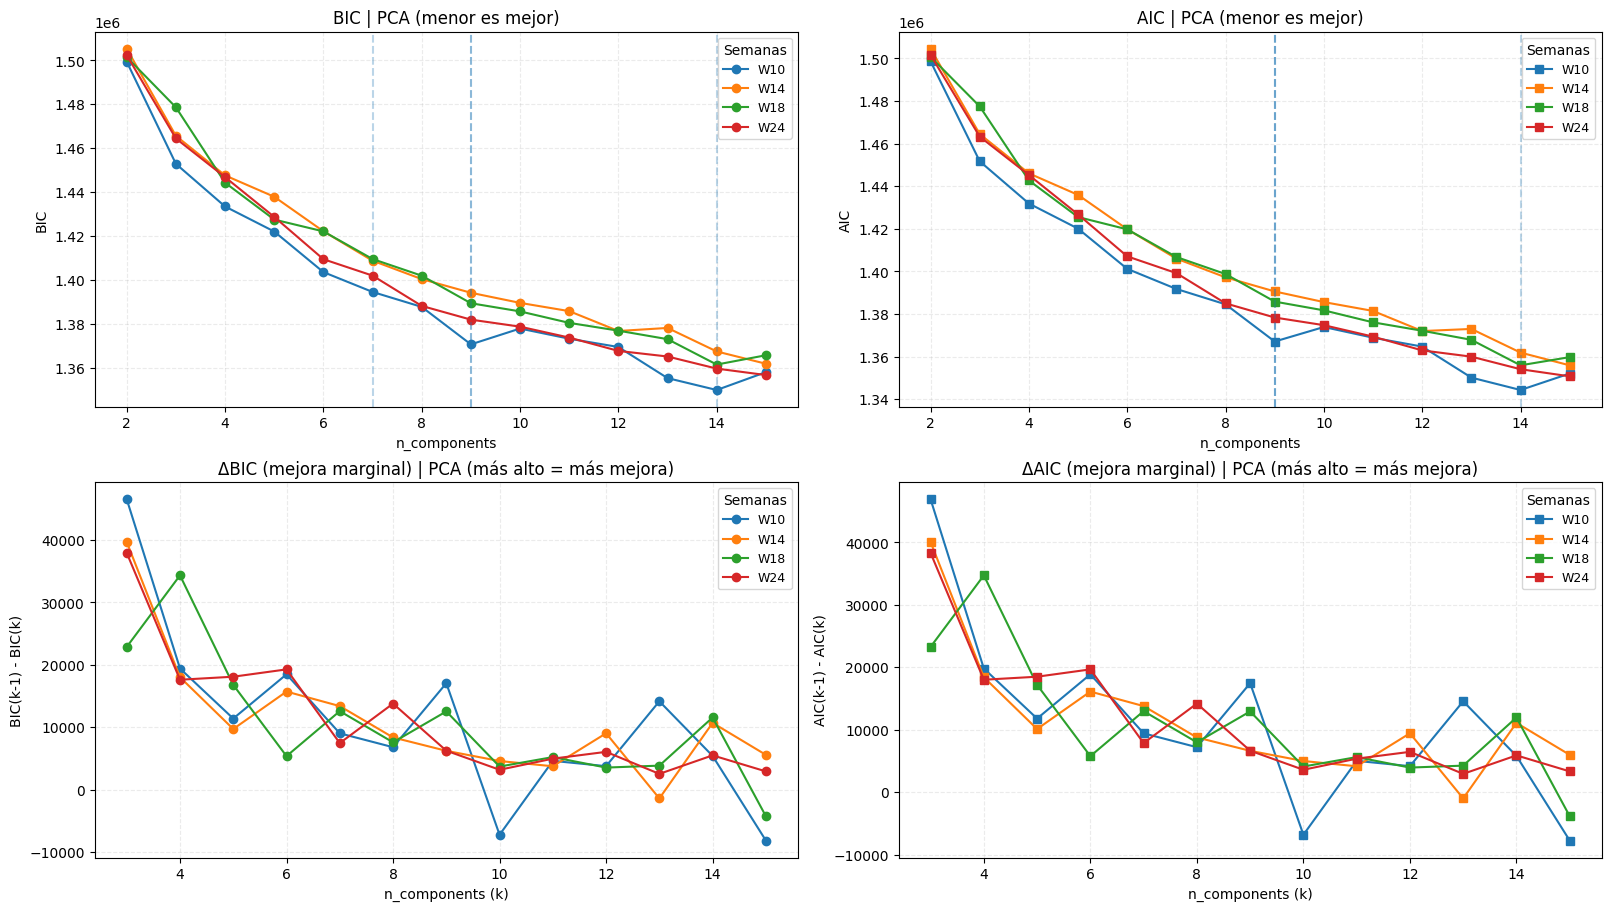

⏳ Ajustando GMM para AE | Semana W10 | n=22785 ...
⏳ Ajustando GMM para AE | Semana W14 | n=22785 ...
⏳ Ajustando GMM para AE | Semana W18 | n=22785 ...
⏳ Ajustando GMM para AE | Semana W24 | n=22785 ...


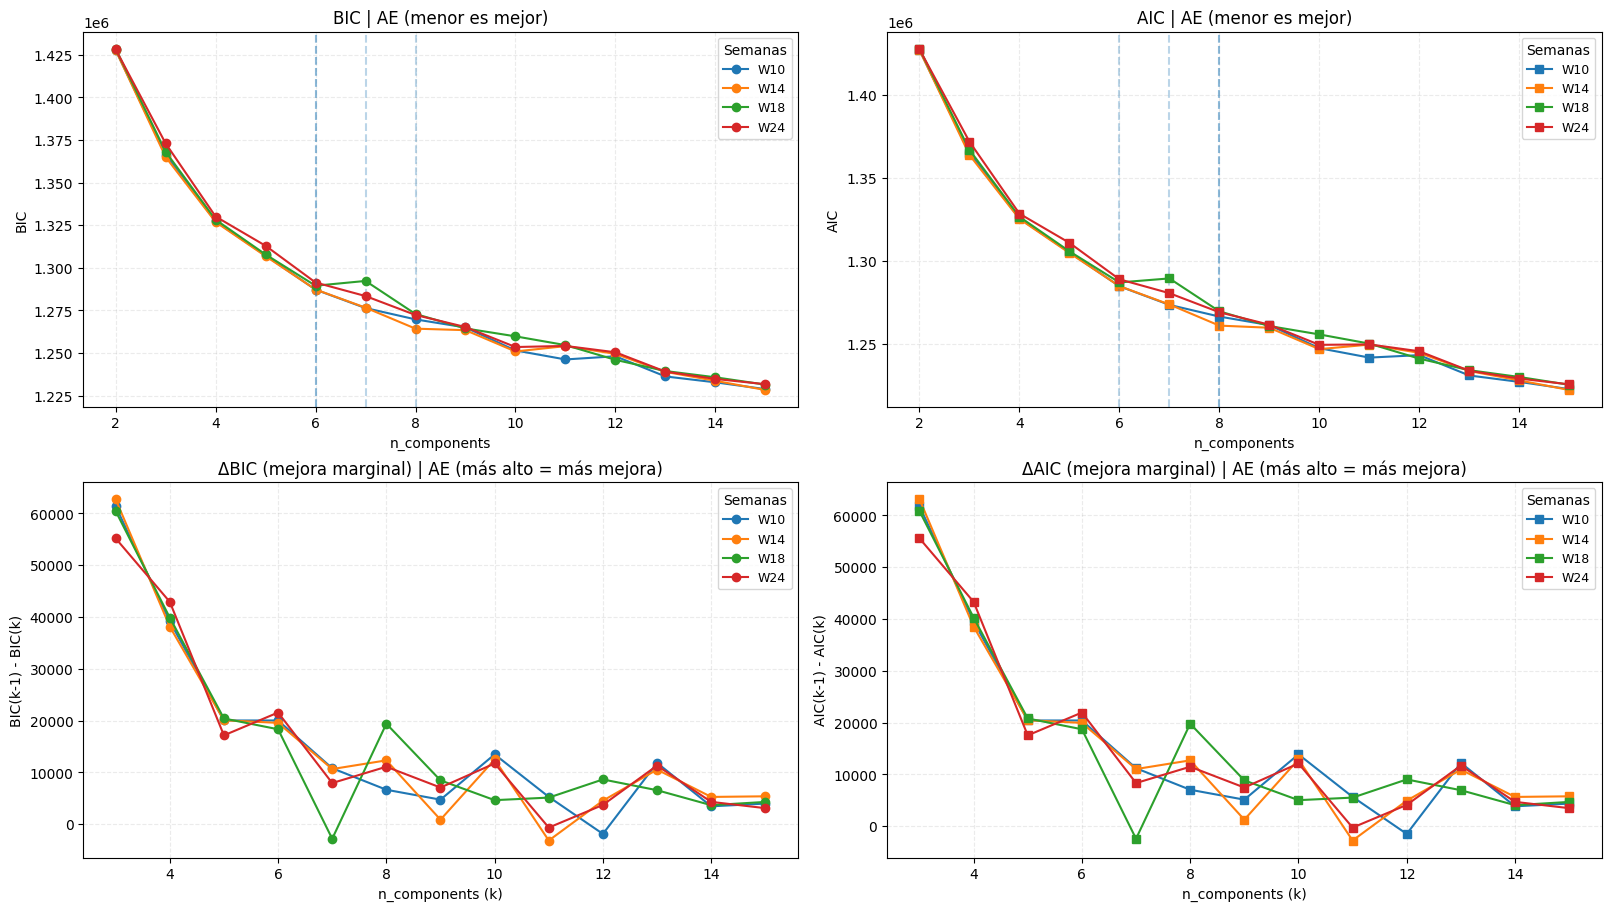


📌 Resumen (por W y tipo):


emb_type   W  n_points_used  k_best_BIC  k_best_AIC  k_knee_BIC  k_knee_AIC  \
4       ae  10          22785          15          15           7           7   
5       ae  14          22785          15          15           8           8   
6       ae  18          22785          15          15           6           6   
7       ae  24          22785          15          15           6           8   
0      pca  10          22785          14          14           7           9   
1      pca  14          22785          15          15           9           9   
2      pca  18          22785          14          14          14          14   
3      pca  24          22785          15          15           9           9   

   all_converged  
4           True  
5           True  
6           True  
7           True  
0           True  
1           True  
2           True  
3           True


✅ Análisis de GMM finalizado.
Tip: si ves BIC/AIC monótonos, mira ΔBIC/ΔAIC para 'diminishing returns'. Puedes ajustar KNEE_DROP_FRACTION=0.15 (0.10–0.25 suele ir bien).


In [7]:
# 📊 Análisis de GMM (BIC/AIC) dinámico y ROBUSTO
# - Lee 4_embeddings/<split>/upto_wXX/{ae|pca}_latent.csv
# - Submuestrea
# - Escala (StandardScaler) ✅
# - GMM con n_init>1 + reg_covar + control de warnings ✅
# - Plots BIC/AIC + mejoras marginales (Δ) para ver "diminishing returns" ✅
# - Imprime tabla resumen con k_best por BIC/AIC y k_sugerido por "knee" (heurística simple) ✅

import re
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler

# -----------------------------
# Configuración del proyecto (si existe)
# -----------------------------
try:
    from educational_ai_analytics.config import EMBEDDINGS_DATA_DIR, W_WINDOWS
    ROOT = Path(EMBEDDINGS_DATA_DIR)
    WS_TO_PLOT = list(W_WINDOWS)
except Exception:
    ROOT = Path("4_embeddings")     # fallback
    WS_TO_PLOT = [12, 18, 24]

# ========= CONFIG =========
MAX_POINTS_GMM = 30000             # submuestreo
COV_TYPE = "diag"                  # "full" | "diag" | "tied" | "spherical"
N_INIT = 5                         # evita óptimos locales
REG_COVAR = 1e-6                   # estabilidad numérica
MAX_ITER = 300
# Heurística "knee": elegimos el primer k donde la mejora marginal cae por debajo de este % de la mejora inicial
KNEE_DROP_FRACTION = 0.15          # 15% (ajústalo 0.1-0.25)
# =========================


def safe_read_csv(path: Path) -> pd.DataFrame:
    if not path.exists():
        return pd.DataFrame()
    return (
        pd.read_csv(path, index_col=0)
        .replace([np.inf, -np.inf], np.nan)
        .fillna(0.0)
    )


def file_for(split_dir: Path, W: int, emb_type: str) -> Path:
    return split_dir / f"upto_w{W:02d}" / f"{emb_type}_latent.csv"


def list_weeks(split_dir: Path) -> list[int]:
    ws = []
    for p in split_dir.iterdir():
        if p.is_dir():
            m = re.match(r"upto_w(\d+)$", p.name)
            if m:
                ws.append(int(m.group(1)))
    return sorted(ws)


def compute_gmm_selection(X: np.ndarray, k_range):
    """
    Devuelve:
      bics: list[float]
      aics: list[float]
      converged: list[bool]
    """
    bics, aics, convs = [], [], []
    for k in k_range:
        try:
            gmm = GaussianMixture(
                n_components=k,
                covariance_type=COV_TYPE,
                random_state=SEED,
                n_init=N_INIT,
                reg_covar=REG_COVAR,
                max_iter=MAX_ITER,
            )
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                gmm.fit(X)

            bics.append(float(gmm.bic(X)))
            aics.append(float(gmm.aic(X)))
            convs.append(bool(getattr(gmm, "converged_", True)))
        except Exception:
            bics.append(np.nan)
            aics.append(np.nan)
            convs.append(False)

    return bics, aics, convs


def knee_from_scores(scores: list[float], ks: list[int], drop_fraction: float = 0.15):
    """
    Heurística simple para "knee" cuando la curva baja monótonamente:
    - Calcula mejoras marginales: improvement(k) = score(k-1) - score(k)  (queremos score más bajo)
    - Toma mejora inicial (entre k_min y k_min+1) como referencia.
    - Devuelve el primer k donde improvement(k) < drop_fraction * improvement_initial.
    Si no encuentra, devuelve el último k.
    """
    s = np.array(scores, dtype=float)
    k = np.array(ks, dtype=int)

    # Si hay NaNs, no podemos hacer heurística fiable
    if np.any(~np.isfinite(s)) or len(s) < 3:
        return int(k[len(k)//2]) if len(k) else None

    improvements = s[:-1] - s[1:]  # cuánto mejora al subir k
    base = improvements[0]
    if base <= 0:
        # no está mejorando o es raro; devuelve el primer k válido
        return int(k[0])

    thresh = drop_fraction * base
    for idx in range(1, len(improvements)):
        if improvements[idx] < thresh:
            return int(k[idx])  # k correspondiente al "segundo" de ese salto
    return int(k[-1])


def argmin_k(scores: list[float], ks: list[int]):
    s = np.array(scores, dtype=float)
    k = np.array(ks, dtype=int)
    mask = np.isfinite(s)
    if not np.any(mask):
        return None
    return int(k[mask][np.argmin(s[mask])])


# ---------- ejecución ----------
split_dir = ROOT / SPLIT
if not split_dir.exists():
    raise FileNotFoundError(f"No existe split_dir: {split_dir.resolve()}")

# Si WS_TO_PLOT viene de config y no coincide con carpetas reales, filtramos
existing_ws = set(list_weeks(split_dir))
if existing_ws:
    WS_TO_PLOT = [w for w in WS_TO_PLOT if w in existing_ws] or sorted(existing_ws)

print(f"🔍 ROOT: {ROOT.resolve()}")
print(f"🔍 SPLIT: {SPLIT}")
print(f"🔍 Evaluando GMM (cov={COV_TYPE}, n_init={N_INIT}, reg_covar={REG_COVAR}) para semanas: {WS_TO_PLOT}")

available_types = [t for t in EMB_TYPES if any(file_for(split_dir, W, t).exists() for W in WS_TO_PLOT)]
if not available_types:
    raise RuntimeError(f"No se encontraron embeddings {EMB_TYPES} en {split_dir.resolve()}")

summary_rows = []

KS = list(K_RANGE)

for emb_type in available_types:
    fig, axes = plt.subplots(2, 2, figsize=(16, 9), constrained_layout=True)
    ax_bic, ax_aic = axes[0, 0], axes[0, 1]
    ax_dbic, ax_daic = axes[1, 0], axes[1, 1]

    for W in WS_TO_PLOT:
        path = file_for(split_dir, W, emb_type)
        if not path.exists():
            continue

        df = safe_read_csv(path)
        if df.empty:
            continue

        if len(df) > MAX_POINTS_GMM:
            df = df.sample(n=MAX_POINTS_GMM, random_state=SEED)

        X = df.values.astype(np.float32)

        # ✅ Escalado recomendado
        X = StandardScaler().fit_transform(X)

        print(f"⏳ Ajustando GMM para {emb_type.upper()} | Semana W{W:02d} | n={len(df)} ...")
        bics, aics, convs = compute_gmm_selection(X, K_RANGE)

        # Best ks
        k_bic = argmin_k(bics, KS)
        k_aic = argmin_k(aics, KS)
        k_knee_bic = knee_from_scores(bics, KS, drop_fraction=KNEE_DROP_FRACTION)
        k_knee_aic = knee_from_scores(aics, KS, drop_fraction=KNEE_DROP_FRACTION)

        summary_rows.append({
            "emb_type": emb_type,
            "W": W,
            "n_points_used": len(df),
            "k_best_BIC": k_bic,
            "k_best_AIC": k_aic,
            "k_knee_BIC": k_knee_bic,
            "k_knee_AIC": k_knee_aic,
            "all_converged": bool(np.all(convs)) if len(convs) else False,
        })

        # Plot BIC / AIC
        ax_bic.plot(KS, bics, marker="o", label=f"W{W:02d}")
        ax_aic.plot(KS, aics, marker="s", label=f"W{W:02d}")

        # Plot mejoras marginales (Δ): cuanto baja al aumentar k
        b = np.array(bics, dtype=float)
        a = np.array(aics, dtype=float)

        # improvements: score(k-1) - score(k)
        db = b[:-1] - b[1:]
        da = a[:-1] - a[1:]

        ax_dbic.plot(KS[1:], db, marker="o", label=f"W{W:02d}")
        ax_daic.plot(KS[1:], da, marker="s", label=f"W{W:02d}")

        # Marcar sugerencias (knee) con líneas verticales ligeras
        if k_knee_bic is not None:
            ax_bic.axvline(k_knee_bic, linestyle="--", alpha=0.3)
        if k_knee_aic is not None:
            ax_aic.axvline(k_knee_aic, linestyle="--", alpha=0.3)

    # Estilo
    ax_bic.set_title(f"BIC | {emb_type.upper()} (menor es mejor)")
    ax_bic.set_xlabel("n_components")
    ax_bic.set_ylabel("BIC")
    ax_bic.grid(True, alpha=0.25, linestyle="--")
    ax_bic.legend(title="Semanas", fontsize=9)

    ax_aic.set_title(f"AIC | {emb_type.upper()} (menor es mejor)")
    ax_aic.set_xlabel("n_components")
    ax_aic.set_ylabel("AIC")
    ax_aic.grid(True, alpha=0.25, linestyle="--")
    ax_aic.legend(title="Semanas", fontsize=9)

    ax_dbic.set_title(f"ΔBIC (mejora marginal) | {emb_type.upper()} (más alto = más mejora)")
    ax_dbic.set_xlabel("n_components (k)")
    ax_dbic.set_ylabel("BIC(k-1) - BIC(k)")
    ax_dbic.grid(True, alpha=0.25, linestyle="--")
    ax_dbic.legend(title="Semanas", fontsize=9)

    ax_daic.set_title(f"ΔAIC (mejora marginal) | {emb_type.upper()} (más alto = más mejora)")
    ax_daic.set_xlabel("n_components (k)")
    ax_daic.set_ylabel("AIC(k-1) - AIC(k)")
    ax_daic.grid(True, alpha=0.25, linestyle="--")
    ax_daic.legend(title="Semanas", fontsize=9)

    plt.show()

# Tabla resumen
summary = pd.DataFrame(summary_rows).sort_values(["emb_type", "W"])
print("\n📌 Resumen (por W y tipo):")
display(summary)

print("\n✅ Análisis de GMM finalizado.")
print(f"Tip: si ves BIC/AIC monótonos, mira ΔBIC/ΔAIC para 'diminishing returns'. "
      f"Puedes ajustar KNEE_DROP_FRACTION={KNEE_DROP_FRACTION} (0.10–0.25 suele ir bien).")


In [9]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from IPython.display import display, Markdown

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# Silenciar ruidos
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
warnings.filterwarnings("ignore")

# ---- Config del proyecto ----
try:
    from educational_ai_analytics.config import EMBEDDINGS_DATA_DIR, W_WINDOWS, FEATURES_DATA_DIR
    LABELS_PATH = FEATURES_DATA_DIR / "training" / "target.csv"
    LABEL_COL = "final_result"
    ROOT = Path(EMBEDDINGS_DATA_DIR)
    WS_TO_PLOT = list(W_WINDOWS)
except Exception:
    ROOT = Path("/workspace/TFM_education_ai_analytics/data/4_embeddings")
    LABELS_PATH = Path("/workspace/TFM_education_ai_analytics/data/3_features/training/target.csv")
    LABEL_COL = "final_result"
    WS_TO_PLOT = [12, 18, 24]

# ========= CONFIG =========
SPLIT = "training"
EMB_TYPES = ["pca", "ae"]
MAX_POINTS_PLOT = 30000
MAX_POINTS_METRICS = 30000

MAP_NUM_TO_STR = {3: "Distinction", 2: "Pass", 1: "Fail", 0: "Withdrawn"}
OUTCOMES = ["Distinction", "Pass", "Fail", "Withdrawn"]
OUTCOME_COLORS = {"Distinction": "#f1c40f", "Pass": "#4c78a8", "Fail": "#e45756", "Withdrawn": "#f4a261"}
# =========================

def safe_read_csv(path: Path) -> pd.DataFrame:
    if not path.exists(): return pd.DataFrame()
    return pd.read_csv(path, index_col=0).replace([np.inf, -np.inf], np.nan).fillna(0.0)

# Cargar labels
labels_df = pd.read_csv(LABELS_PATH, index_col=0)
y_outcome = labels_df[LABEL_COL].map(MAP_NUM_TO_STR)
global_success = (labels_df[LABEL_COL] >= 2).mean() * 100

# ==========================================
# 1. CÁLCULO DE MÉTRICAS Y TABLA SUMMARY
# ==========================================
metrics_results = []
for W in WS_TO_PLOT:
    for emb_type in EMB_TYPES:
        path = ROOT / SPLIT / f"upto_w{W:02d}" / f"{emb_type}_latent.csv"
        if not path.exists(): continue
        df_lat = safe_read_csv(path).loc[labels_df.index].dropna()
        if len(df_lat) > MAX_POINTS_METRICS:
            df_lat = df_lat.sample(n=MAX_POINTS_METRICS, random_state=SEED)
        X = StandardScaler().fit_transform(df_lat.values.astype(np.float32))
        gmm = GaussianMixture(
            n_components=K,
            covariance_type="tied",
            init_params="kmeans",
            n_init=20,
            max_iter=1000,
            tol=1e-3,
            reg_covar=1e-5,
            random_state=SEED,
        )
        cl = gmm.fit_predict(X)
        metrics_results.append({
            "Semana": W, "Embedding": emb_type.upper(), 
            "Silueta": silhouette_score(X, cl), 
            "Calinski-Harabasz": calinski_harabasz_score(X, cl), 
            "Davies-Bouldin": davies_bouldin_score(X, cl)
        })

df_stats = pd.DataFrame(metrics_results)
metric_meta = [
    ("Silueta", "Maximizar", "Mide separación y cohesión (-1 a 1)."),
    ("Calinski-Harabasz", "Maximizar", "Ratio de dispersión entre/dentro de clústeres."),
    ("Davies-Bouldin", "Minimizar", "Mide similitud media entre clústeres.")
]

summary_table = []
for name, obj, desc in metric_meta:
    for W in WS_TO_PLOT:
        row = {"Métrica": f"{name} (W{W})", "Objetivo": obj, "Descripción": desc}
        for emb in ["PCA", "AE"]:
            val = df_stats[(df_stats["Semana"] == W) & (df_stats["Embedding"] == emb)][name].values
            row[f"Valor {emb}"] = f"{val[0]:.4f}" if len(val) > 0 else "N/A"
        summary_table.append(row)

display(Markdown("### 📊 Calidad de Clustering (GMM): PCA vs Autoencoder"))
display(pd.DataFrame(summary_table))

# ==========================================
# 2. GENERACIÓN DE GRÁFICOS
# ==========================================
def plot_freq_bars(ax, df_join: pd.DataFrame, group_order: list[str], title: str):
    tab = pd.crosstab(df_join["group"], df_join["outcome"], normalize="index") * 100
    for out in OUTCOMES:
        if out not in tab.columns: tab[out] = 0.0
    tab = tab.loc[group_order, OUTCOMES]
    x = np.arange(len(group_order))
    width = 0.18
    for i, out in enumerate(OUTCOMES):
        ax.bar(x + (i - 1.5) * width, tab[out].values, width=width, label=out, color=OUTCOME_COLORS[out])
    ax.axhline(global_success, color="black", linestyle="--", alpha=0.3)
    ax.set_title(title, fontsize=10)
    ax.set_xticks(x); ax.set_xticklabels(group_order, fontsize=8); ax.set_ylim(0, 115)

# Acondicionar grid
Ws = [W for W in WS_TO_PLOT if any((ROOT / SPLIT / f"upto_w{W:02d}" / f"{t}_latent.csv").exists() for t in EMB_TYPES)]
nrows = len(Ws)
fig, axes = plt.subplots(nrows, 4, figsize=(22, 5.5*nrows), constrained_layout=True)
if nrows == 1: axes = np.expand_dims(axes, axis=0)

handles = [plt.Line2D([0], [0], marker="o", color="w", markerfacecolor=OUTCOME_COLORS[out], markersize=10, label=out) for out in OUTCOMES]
fig.legend(handles=handles, labels=OUTCOMES, loc="upper center", ncol=4, frameon=False, fontsize=12)

for r, W in enumerate(Ws):
    for c, emb_type in enumerate(["pca", "ae"]):
        df_emb = safe_read_csv(ROOT / SPLIT / f"upto_w{W:02d}" / f"{emb_type}_latent.csv")
        df_join = df_emb.join(y_outcome.rename("outcome"), how="inner")
        if len(df_join) > MAX_POINTS_PLOT:
            df_join = df_join.sample(n=MAX_POINTS_PLOT, random_state=SEED)

        X = StandardScaler().fit_transform(df_join.drop(columns=["outcome"]).values.astype(np.float32))
        gmm = GaussianMixture(n_components=K, covariance_type="diag", n_init=10, random_state=SEED)
        df_join["cluster"] = gmm.fit_predict(X)
        
        # Ordenar por éxito (Pass + Distinction)
        rates = df_join.groupby("cluster")["outcome"].apply(lambda s: np.mean([v in ("Pass", "Distinction") for v in s])).sort_values()
        mapping = {cl: (f"Riesgo {i}" if i==0 else (f"Top {K}" if i==K-1 else f"G{i}")) for i, cl in enumerate(rates.index)}
        df_join["group"] = df_join["cluster"].map(mapping)
        group_order = [mapping[cl] for cl in rates.index]

        Z2 = PCA(n_components=2, random_state=SEED).fit_transform(X)
        
        # Scatter (Color por OUTCOME para ver distribución real)
        ax_sc = axes[r, c*2]
        for out in OUTCOMES:
            m = df_join["outcome"] == out
            ax_sc.scatter(Z2[m, 0], Z2[m, 1], s=5, alpha=0.6, c=OUTCOME_COLORS[out])
        ax_sc.set_title(f"W{W} | {emb_type.upper()} | Vista PCA", fontsize=10, fontweight='bold')
        ax_sc.set_xticks([]); ax_sc.set_yticks([])

        # Bars
        plot_freq_bars(axes[r, c*2+1], df_join, group_order, f"Frecuencias W{W} {emb_type.upper()}")

plt.show()

KeyboardInterrupt: 

In [ ]:
import os
import warnings
import numpy as np
import pandas as pd
from pathlib import Path
from IPython.display import display, Markdown

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# Silenciar ruidos
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
warnings.filterwarnings("ignore")

# ---- Configuración de Rutas ----
try:
    from educational_ai_analytics.config import EMBEDDINGS_DATA_DIR, W_WINDOWS, FEATURES_DATA_DIR
    ROOT = Path(EMBEDDINGS_DATA_DIR)
    WS_TO_PLOT = list(W_WINDOWS)
except Exception:
    ROOT = Path("/workspace/TFM_education_ai_analytics/data/4_embeddings")
    WS_TO_PLOT = [12, 18, 24]

# ========= CONFIGURACIÓN =========
SPLIT = "training"
K = 5
MAX_POINTS_METRICS = 5000  # Para velocidad
# =================================

def safe_read_csv(path: Path) -> pd.DataFrame:
    if not path.exists(): return pd.DataFrame()
    return pd.read_csv(path, index_col=0).replace([np.inf, -np.inf], np.nan).fillna(0.0)

results = []

for W in WS_TO_PLOT:
    for emb_type in ["pca", "ae"]:
        path = ROOT / SPLIT / f"upto_w{W:02d}" / f"{emb_type}_latent.csv"
        if not path.exists(): continue
        
        df_lat = safe_read_csv(path)
        if len(df_lat) > MAX_POINTS_METRICS:
            df_lat = df_lat.sample(n=MAX_POINTS_METRICS, random_state=SEED)
            
        X = StandardScaler().fit_transform(df_lat.values.astype(np.float32))
        
        # --- K-MEANS ---
        km = KMeans(n_clusters=K, n_init=10, random_state=SEED)
        km_labels = km.fit_predict(X)
        
        # --- GMM ---
        gmm = GaussianMixture(n_components=K, covariance_type="diag", n_init=5, random_state=SEED)
        gmm_labels = gmm.fit_predict(X)
        
        # Guardar métricas para ambos
        for model_name, labels in [("K-Means", km_labels), ("GMM", gmm_labels)]:
            results.append({
                "Semana": f"W{W}",
                "Embedding": emb_type.upper(),
                "Modelo": model_name,
                "Silueta": silhouette_score(X, labels),
                "Calinski-Harabasz": calinski_harabasz_score(X, labels),
                "Davies-Bouldin": davies_bouldin_score(X, labels)
            })

df_all = pd.DataFrame(results)

def display_comparison_table(emb_type):
    df_emb = df_all[df_all["Embedding"] == emb_type]
    
    # Crear estructura de tabla comparativa
    table_rows = []
    metrics = [("Silueta", "Maximizar"), ("Calinski-Harabasz", "Maximizar"), ("Davies-Bouldin", "Minimizar")]
    
    for metric, obj in metrics:
        for W in [f"W{w}" for w in WS_TO_PLOT]:
            subset = df_emb[df_emb["Semana"] == W]
            val_km = subset[subset["Modelo"] == "K-Means"][metric].values[0]
            val_gmm = subset[subset["Modelo"] == "GMM"][metric].values[0]
            
            # Marcar el ganador
            if obj == "Maximizar":
                win = "GMM" if val_gmm > val_km else "K-Means"
            else:
                win = "GMM" if val_gmm < val_km else "K-Means"
                
            table_rows.append({
                "Métrica": f"{metric} ({W})",
                "K-Means": f"{val_km:.4f}",
                "GMM": f"{val_gmm:.4f}",
                "Objetivo": obj,
                "Ganador": f"⭐ {win}"
            })
    
    display(Markdown(f"### 🏆 Comparativa Modelos: **{emb_type}**"))
    display(pd.DataFrame(table_rows))

# Generar las dos tablas
display_comparison_table("PCA")
display_comparison_table("AE")

### 🏆 Comparativa Modelos: **PCA**

Métrica   K-Means       GMM   Objetivo    Ganador
0              Silueta (W8)    0.0842    0.0378  Maximizar  ⭐ K-Means
1             Silueta (W16)    0.0587    0.0082  Maximizar  ⭐ K-Means
2             Silueta (W20)    0.0652    0.0371  Maximizar  ⭐ K-Means
3             Silueta (W24)    0.0561    0.0187  Maximizar  ⭐ K-Means
4    Calinski-Harabasz (W8)  218.6337  160.2611  Maximizar  ⭐ K-Means
5   Calinski-Harabasz (W16)  194.2689  140.8224  Maximizar  ⭐ K-Means
6   Calinski-Harabasz (W20)  189.1450  152.3591  Maximizar  ⭐ K-Means
7   Calinski-Harabasz (W24)  198.2336  150.9433  Maximizar  ⭐ K-Means
8       Davies-Bouldin (W8)    2.9633    4.4200  Minimizar  ⭐ K-Means
9      Davies-Bouldin (W16)    3.2499    4.0440  Minimizar  ⭐ K-Means
10     Davies-Bouldin (W20)    3.3650    4.3297  Minimizar  ⭐ K-Means
11     Davies-Bouldin (W24)    3.0174    4.2220  Minimizar  ⭐ K-Means

### 🏆 Comparativa Modelos: **AE**

Métrica   K-Means       GMM   Objetivo    Ganador
0              Silueta (W8)    0.1195    0.0911  Maximizar  ⭐ K-Means
1             Silueta (W16)    0.1186    0.0912  Maximizar  ⭐ K-Means
2             Silueta (W20)    0.1170    0.0945  Maximizar  ⭐ K-Means
3             Silueta (W24)    0.1172    0.0944  Maximizar  ⭐ K-Means
4    Calinski-Harabasz (W8)  543.4534  497.9486  Maximizar  ⭐ K-Means
5   Calinski-Harabasz (W16)  590.5827  537.6655  Maximizar  ⭐ K-Means
6   Calinski-Harabasz (W20)  585.3915  517.0334  Maximizar  ⭐ K-Means
7   Calinski-Harabasz (W24)  584.8226  534.3171  Maximizar  ⭐ K-Means
8       Davies-Bouldin (W8)    2.3585    2.6446  Minimizar  ⭐ K-Means
9      Davies-Bouldin (W16)    2.3226    2.4774  Minimizar  ⭐ K-Means
10     Davies-Bouldin (W20)    2.3220    2.5336  Minimizar  ⭐ K-Means
11     Davies-Bouldin (W24)    2.3170    2.5414  Minimizar  ⭐ K-Means

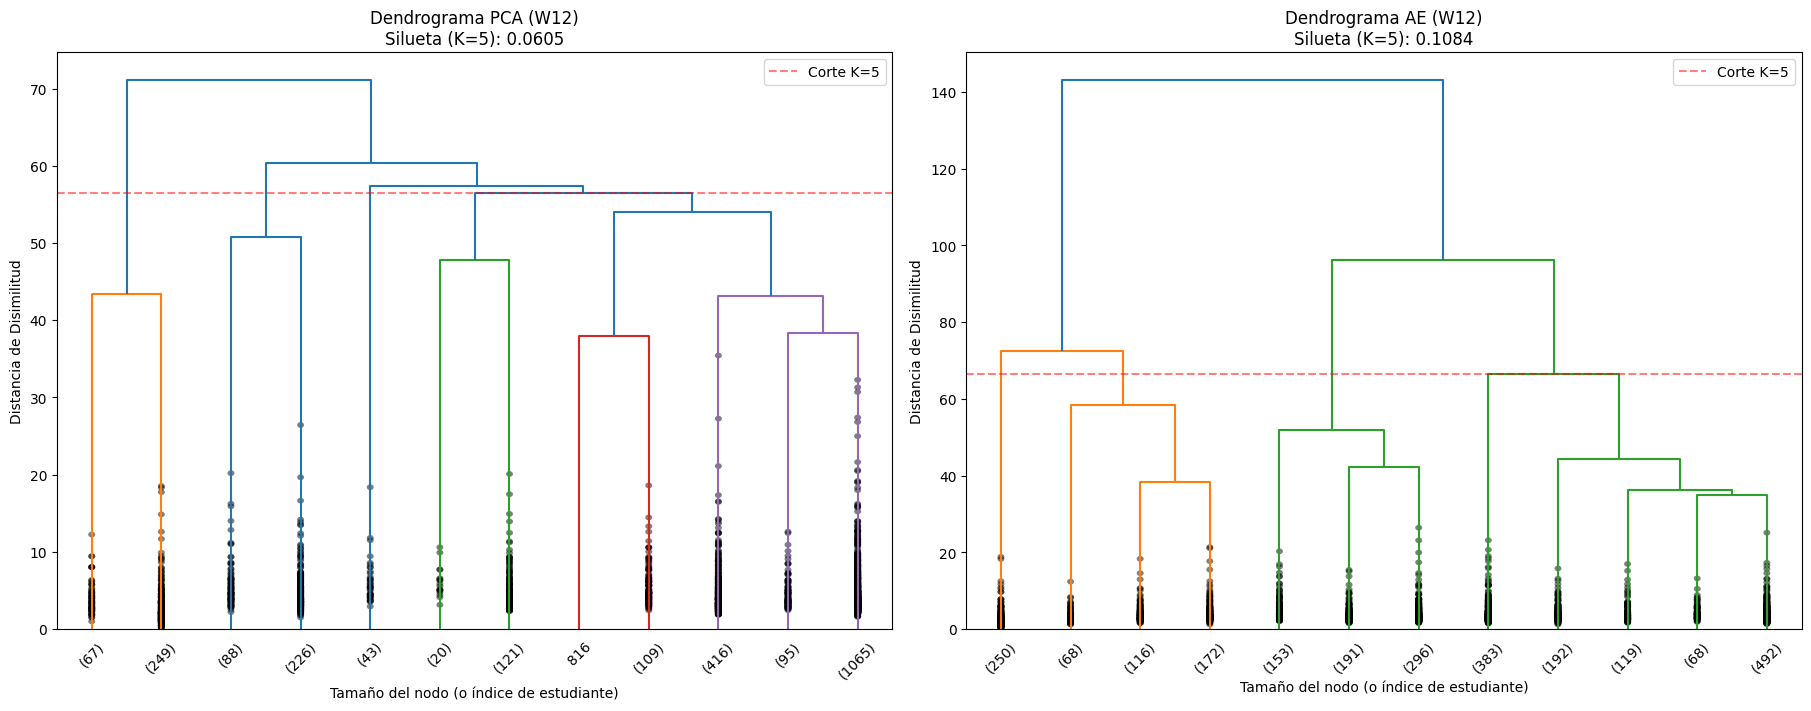

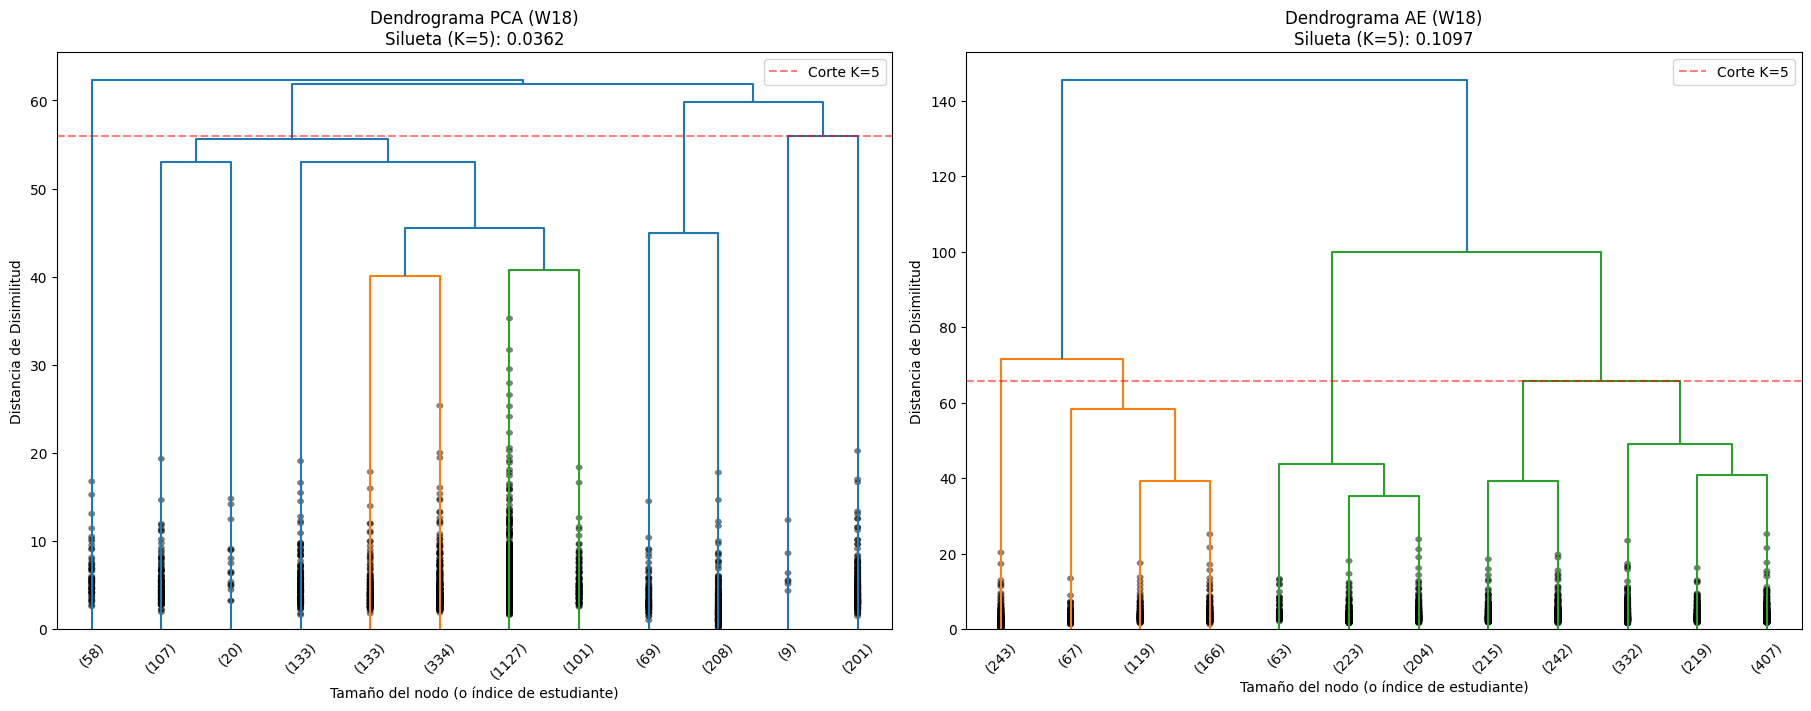

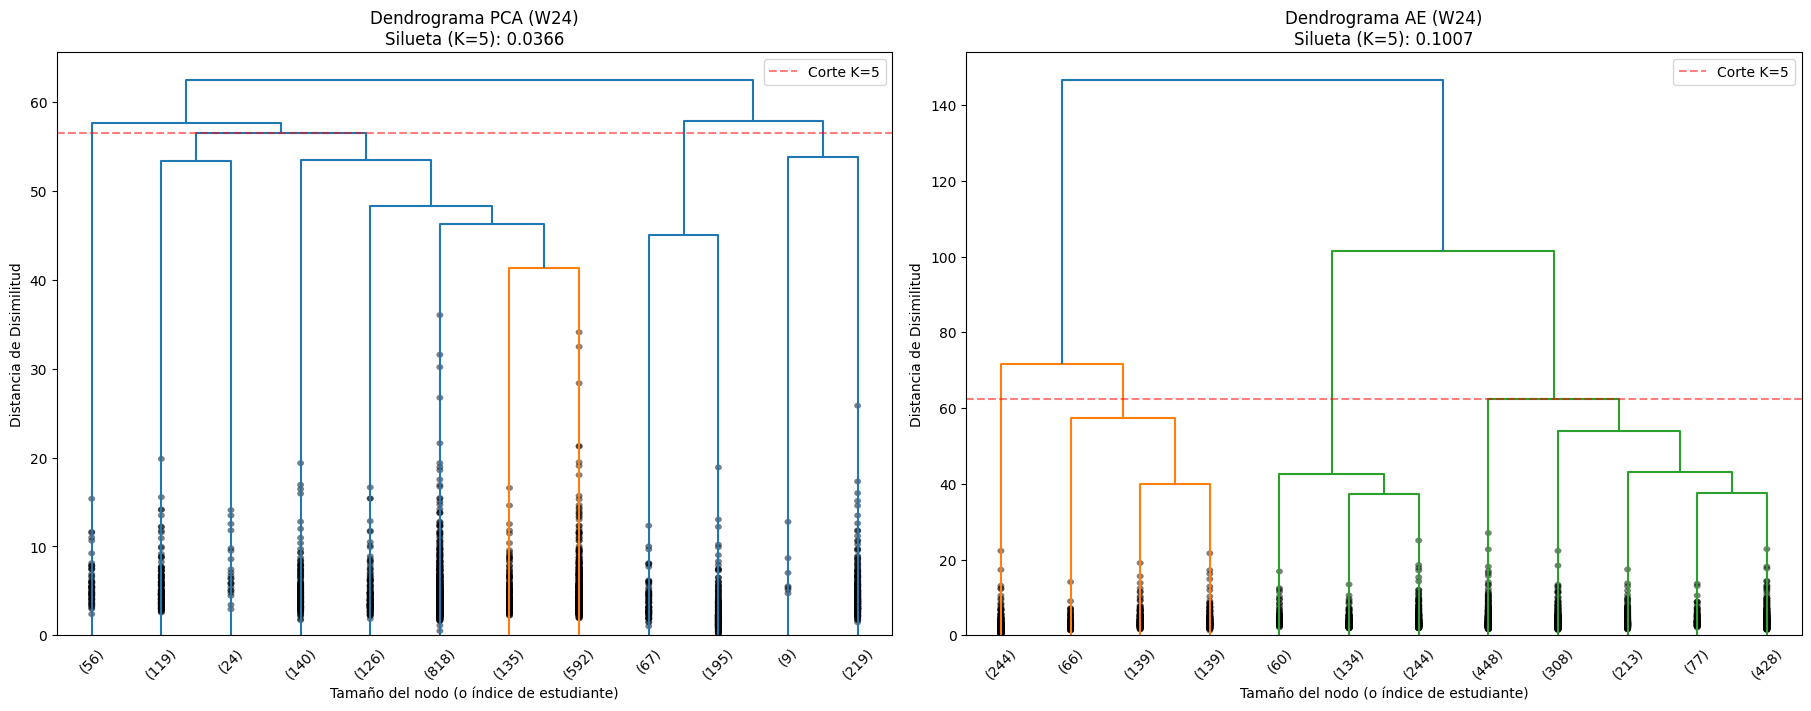

✅ Análisis Jerárquico completado.


In [ ]:
# 🌳 Clustering Jerárquico y Dendrogramas
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

# ---- Configuración de Rutas ----
try:
    from educational_ai_analytics.config import EMBEDDINGS_DATA_DIR, W_WINDOWS
    ROOT = Path(EMBEDDINGS_DATA_DIR)
    WS_TO_PLOT = list(W_WINDOWS)
except Exception:
    ROOT = Path("/workspace/TFM_education_ai_analytics/data/4_embeddings")
    WS_TO_PLOT = [12, 18, 24]

# ========= CONFIGURACIÓN =========
SPLIT = "training"
K = 5
MAX_POINTS_HIERARCHICAL = 2500  # <--- Mantén esto bajo (2000-3000) para evitar cuelgues
METRIC = "euclidean"
LINKAGE = "ward"  # "ward" minimiza la varianza dentro de los clusters
# =================================

def safe_read_csv(path: Path) -> pd.DataFrame:
    if not path.exists(): return pd.DataFrame()
    return pd.read_csv(path, index_col=0).replace([np.inf, -np.inf], np.nan).fillna(0.0)

for W in WS_TO_PLOT:
    fig, axes = plt.subplots(1, 2, figsize=(18, 7), constrained_layout=True)
    
    for j, emb_type in enumerate(["pca", "ae"]):
        ax = axes[j]
        path = ROOT / SPLIT / f"upto_w{W:02d}" / f"{emb_type}_latent.csv"
        if not path.exists(): continue
        
        df_lat = safe_read_csv(path)
        # Muestreo limitado por complejidad O(N^2)
        if len(df_lat) > MAX_POINTS_HIERARCHICAL:
            df_lat = df_lat.sample(n=MAX_POINTS_HIERARCHICAL, random_state=SEED)
            
        X = StandardScaler().fit_transform(df_lat.values.astype(np.float32))
        
        # 1. Generar la matriz de enlace (Linkage Matrix)
        Z = linkage(X, method=LINKAGE, metric=METRIC)
        
        # 2. Dibujar Dendrograma
        dendrogram(
            Z,
            truncate_mode='lastp',  # mostrar solo los últimos p clusters fusionados
            p=12,                   # número de ramas finales
            leaf_rotation=45.,
            leaf_font_size=10.,
            show_contracted=True,
            ax=ax
        )
        
        # 3. Calcular Silueta para K sugerido
        agg = AgglomerativeClustering(n_clusters=K, linkage=LINKAGE)
        labels = agg.fit_predict(X)
        s_score = silhouette_score(X, labels)
        
        ax.set_title(f"Dendrograma {emb_type.upper()} (W{W})\nSilueta (K={K}): {s_score:.4f}")
        ax.set_xlabel("Tamaño del nodo (o índice de estudiante)")
        ax.set_ylabel("Distancia de Disimilitud")
        ax.axhline(y=Z[-(K-1), 2], color='r', linestyle='--', alpha=0.5, label=f'Corte K={K}')
        ax.legend()

    plt.show()

print("✅ Análisis Jerárquico completado.")

### 📊 Calidad de Clustering Jerárquico (ward): PCA vs Autoencoder

Métrica   Objetivo  \
0            Silueta (W12)  Maximizar   
1            Silueta (W18)  Maximizar   
2            Silueta (W24)  Maximizar   
3  Calinski-Harabasz (W12)  Maximizar   
4  Calinski-Harabasz (W18)  Maximizar   
5  Calinski-Harabasz (W24)  Maximizar   
6     Davies-Bouldin (W12)  Minimizar   
7     Davies-Bouldin (W18)  Minimizar   
8     Davies-Bouldin (W24)  Minimizar   

                                        Descripción Valor PCA  Valor AE  
0     Diferenciación y cohesión de ramas del árbol.    0.0565    0.1065  
1     Diferenciación y cohesión de ramas del árbol.    0.0413    0.1008  
2     Diferenciación y cohesión de ramas del árbol.    0.0331    0.0962  
3              Ratio de dispersión de la jerarquía.  113.4463  352.7404  
4              Ratio de dispersión de la jerarquía.  107.4284  369.4886  
5              Ratio de dispersión de la jerarquía.   99.3015  384.5945  
6  Similitud media entre las hojas de la jerarquía.    2.5834    2.4379  
7  Similitud media entre las hojas de la jerarquía.    2.1651    2.3595  
8  Similitud media entre las hojas de la jerarquía.    2.2157    2.4116

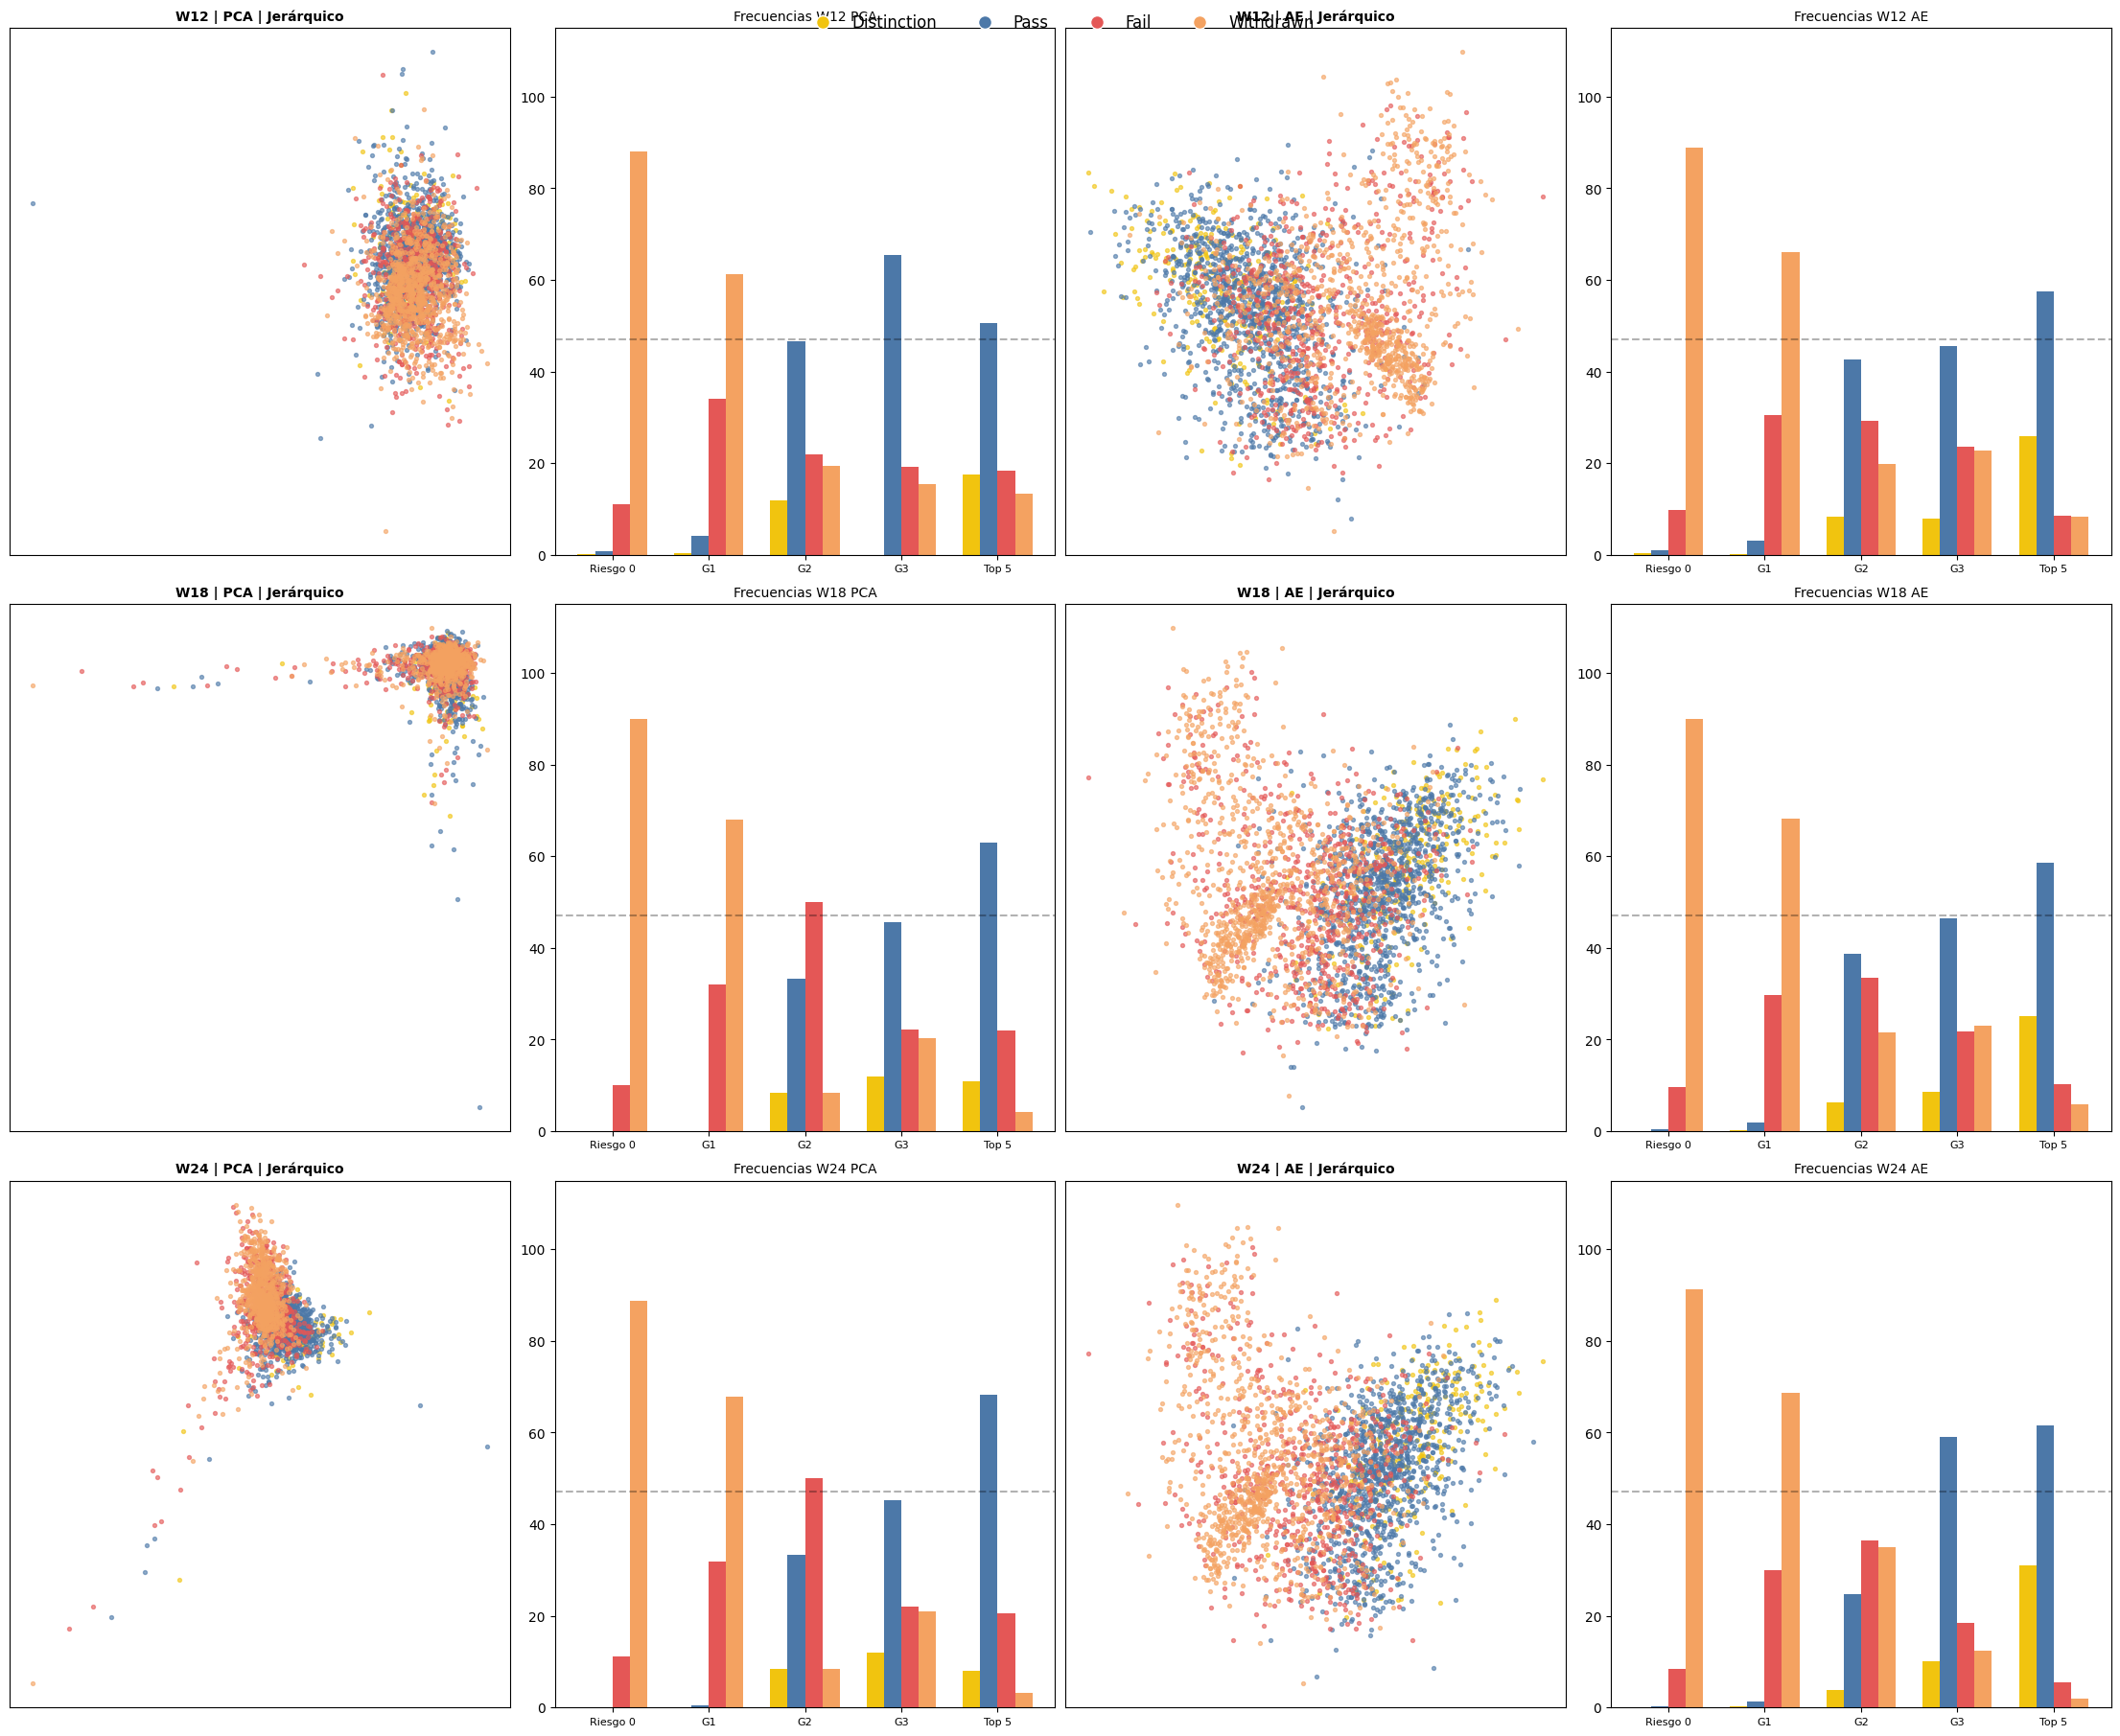

In [ ]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from IPython.display import display, Markdown

from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# Silenciar ruidos
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
warnings.filterwarnings("ignore")

# ---- Configuración de Rutas ----
try:
    from educational_ai_analytics.config import EMBEDDINGS_DATA_DIR, W_WINDOWS, FEATURES_DATA_DIR
    ROOT = Path(EMBEDDINGS_DATA_DIR)
    TARGET_PATH = Path(FEATURES_DATA_DIR) / "training" / "target.csv"
    WS_TO_PLOT = list(W_WINDOWS)
except Exception:
    ROOT = Path("/workspace/TFM_education_ai_analytics/data/4_embeddings")
    TARGET_PATH = Path("/workspace/TFM_education_ai_analytics/data/3_features/training/target.csv")
    WS_TO_PLOT = [12, 18, 24]

# ========= CONFIGURACIÓN =========
SPLIT = "training"
EMB_TYPES = ["pca", "ae"]
K = 5
MAX_POINTS_PLOT = 3000   # Límite para visualización
MAX_POINTS_METRICS = 3000 # Límite para cálculo de métricas (Jerárquico es O(N^2))
LINKAGE = "ward"

MAP_NUM_TO_STR = {3: "Distinction", 2: "Pass", 1: "Fail", 0: "Withdrawn"}
OUTCOMES = ["Distinction", "Pass", "Fail", "Withdrawn"]
OUTCOME_COLORS = {"Distinction": "#f1c40f", "Pass": "#4c78a8", "Fail": "#e45756", "Withdrawn": "#f4a261"}
# =================================

def safe_read_csv(path: Path) -> pd.DataFrame:
    if not path.exists(): return pd.DataFrame()
    return pd.read_csv(path, index_col=0).replace([np.inf, -np.inf], np.nan).fillna(0.0)

# Cargar labels
labels_df = pd.read_csv(TARGET_PATH, index_col=0)
y_outcome = labels_df["final_result"].map(MAP_NUM_TO_STR)
global_success = (labels_df["final_result"] >= 2).mean() * 100

# ==========================================
# 1. CÁLCULO DE MÉTRICAS Y TABLA SUMMARY
# ==========================================
metrics_results = []
for W in WS_TO_PLOT:
    for emb_type in EMB_TYPES:
        path = ROOT / SPLIT / f"upto_w{W:02d}" / f"{emb_type}_latent.csv"
        if not path.exists(): continue
        df_lat = safe_read_csv(path).loc[labels_df.index].dropna()
        if len(df_lat) > MAX_POINTS_METRICS:
            df_lat = df_lat.sample(n=MAX_POINTS_METRICS, random_state=SEED)
        
        X = StandardScaler().fit_transform(df_lat.values.astype(np.float32))
        agg = AgglomerativeClustering(n_clusters=K, linkage=LINKAGE)
        labels = agg.fit_predict(X)
        
        metrics_results.append({
            "Semana": W, "Embedding": emb_type.upper(), 
            "Silueta": silhouette_score(X, labels), 
            "Calinski-Harabasz": calinski_harabasz_score(X, labels), 
            "Davies-Bouldin": davies_bouldin_score(X, labels)
        })

df_stats = pd.DataFrame(metrics_results)
metric_meta = [
    ("Silueta", "Maximizar", "Diferenciación y cohesión de ramas del árbol."),
    ("Calinski-Harabasz", "Maximizar", "Ratio de dispersión de la jerarquía."),
    ("Davies-Bouldin", "Minimizar", "Similitud media entre las hojas de la jerarquía.")
]

summary_table = []
for name, obj, desc in metric_meta:
    for W in WS_TO_PLOT:
        row = {"Métrica": f"{name} (W{W})", "Objetivo": obj, "Descripción": desc}
        for emb in ["PCA", "AE"]:
            val = df_stats[(df_stats["Semana"] == W) & (df_stats["Embedding"] == emb)][name].values
            row[f"Valor {emb}"] = f"{val[0]:.4f}" if len(val) > 0 else "N/A"
        summary_table.append(row)

display(Markdown(f"### 📊 Calidad de Clustering Jerárquico ({LINKAGE}): PCA vs Autoencoder"))
display(pd.DataFrame(summary_table))

# ==========================================
# 2. GENERACIÓN DE GRÁFICOS
# ==========================================
def plot_freq_bars(ax, df_join: pd.DataFrame, group_order: list[str], title: str):
    tab = pd.crosstab(df_join["group"], df_join["outcome"], normalize="index") * 100
    for out in OUTCOMES:
        if out not in tab.columns: tab[out] = 0.0
    tab = tab.loc[group_order, OUTCOMES]
    x = np.arange(len(group_order))
    width = 0.18
    for i, out in enumerate(OUTCOMES):
        ax.bar(x + (i - 1.5) * width, tab[out].values, width=width, label=out, color=OUTCOME_COLORS[out])
    ax.axhline(global_success, color="black", linestyle="--", alpha=0.3)
    ax.set_title(title, fontsize=10); ax.set_xticks(x); ax.set_xticklabels(group_order, fontsize=8); ax.set_ylim(0, 115)

Ws = [W for W in WS_TO_PLOT if any((ROOT / SPLIT / f"upto_w{W:02d}" / f"{t}_latent.csv").exists() for t in EMB_TYPES)]
nrows = len(Ws); fig, axes = plt.subplots(nrows, 4, figsize=(22, 6 * nrows), constrained_layout=True)
if nrows == 1: axes = np.expand_dims(axes, axis=0)

handles = [plt.Line2D([0], [0], marker="o", color="w", markerfacecolor=OUTCOME_COLORS[out], markersize=10, label=out) for out in OUTCOMES]
fig.legend(handles=handles, labels=OUTCOMES, loc="upper center", ncol=4, frameon=False, fontsize=12)

for r, W in enumerate(Ws):
    for c, emb_type in enumerate(["pca", "ae"]):
        df_emb = safe_read_csv(ROOT / SPLIT / f"upto_w{W:02d}" / f"{emb_type}_latent.csv")
        df_join = df_emb.join(y_outcome.rename("outcome"), how="inner")
        if len(df_join) > MAX_POINTS_PLOT:
            df_join = df_join.sample(n=MAX_POINTS_PLOT, random_state=SEED)

        X_plot = StandardScaler().fit_transform(df_join.drop(columns=["outcome"]).values.astype(np.float32))
        agg = AgglomerativeClustering(n_clusters=K, linkage=LINKAGE)
        df_join["cluster"] = agg.fit_predict(X_plot)
        
        rates = df_join.groupby("cluster")["outcome"].apply(lambda s: np.mean([v in ("Pass", "Distinction") for v in s])).sort_values()
        mapping = {cl: (f"Riesgo {i}" if i==0 else (f"Top {K}" if i==K-1 else f"G{i}")) for i, cl in enumerate(rates.index)}
        df_join["group"] = df_join["cluster"].map(mapping); group_order = [mapping[cl] for cl in rates.index]

        Z2 = PCA(n_components=2, random_state=SEED).fit_transform(X_plot)
        ax_sc = axes[r, c*2]
        for out in OUTCOMES:
            m = df_join["outcome"] == out
            ax_sc.scatter(Z2[m, 0], Z2[m, 1], s=8, alpha=0.6, c=OUTCOME_COLORS[out])
        ax_sc.set_title(f"W{W} | {emb_type.upper()} | Jerárquico", fontsize=10, fontweight='bold')
        ax_sc.set_xticks([]); ax_sc.set_yticks([])

        plot_freq_bars(axes[r, c*2+1], df_join, group_order, f"Frecuencias W{W} {emb_type.upper()}")

plt.show()

In [ ]:
import os
import warnings
import numpy as np
import pandas as pd
from pathlib import Path
from IPython.display import display, Markdown

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# Silenciar ruidos
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
warnings.filterwarnings("ignore")

# ---- Configuración de Rutas ----
try:
    from educational_ai_analytics.config import EMBEDDINGS_DATA_DIR, W_WINDOWS, FEATURES_DATA_DIR
    ROOT = Path(EMBEDDINGS_DATA_DIR)
    WS_TO_PLOT = list(W_WINDOWS)
except Exception:
    ROOT = Path("/workspace/TFM_education_ai_analytics/data/4_embeddings")
    WS_TO_PLOT = [12, 18, 24]

# ========= CONFIGURACIÓN =========
SPLIT = "training"
K = 5
MAX_POINTS_METRICS = 3000  # Ajustado para que el Jerárquico no tarde demasiado
SEED = 42
LINKAGE = "ward"
# =================================

def safe_read_csv(path: Path) -> pd.DataFrame:
    if not path.exists(): return pd.DataFrame()
    return pd.read_csv(path, index_col=0).replace([np.inf, -np.inf], np.nan).fillna(0.0)

results = []

for W in WS_TO_PLOT:
    for emb_type in ["pca", "ae"]:
        path = ROOT / SPLIT / f"upto_w{W:02d}" / f"{emb_type}_latent.csv"
        if not path.exists(): continue
        
        df_lat = safe_read_csv(path)
        if len(df_lat) > MAX_POINTS_METRICS:
            df_lat = df_lat.sample(n=MAX_POINTS_METRICS, random_state=SEED)
            
        X = StandardScaler().fit_transform(df_lat.values.astype(np.float32))
        
        # --- 1. K-MEANS ---
        km = KMeans(n_clusters=K, n_init=10, random_state=SEED)
        km_labels = km.fit_predict(X)
        
        # --- 2. GMM ---
        gmm = GaussianMixture(n_components=K, covariance_type="diag", n_init=5, random_state=SEED)
        gmm_labels = gmm.fit_predict(X)

        # --- 3. JERÁRQUICO ---
        agg = AgglomerativeClustering(n_clusters=K, linkage=LINKAGE)
        agg_labels = agg.fit_predict(X)
        
        # Guardar métricas para los tres
        for model_name, labels in [("K-Means", km_labels), ("GMM", gmm_labels), ("Jerárquico", agg_labels)]:
            results.append({
                "Semana": f"W{W}",
                "Embedding": emb_type.upper(),
                "Modelo": model_name,
                "Silueta": silhouette_score(X, labels),
                "Calinski-Harabasz": calinski_harabasz_score(X, labels),
                "Davies-Bouldin": davies_bouldin_score(X, labels)
            })

df_all = pd.DataFrame(results)

def display_comparison_table(emb_type):
    df_emb = df_all[df_all["Embedding"] == emb_type]
    
    table_rows = []
    metrics = [("Silueta", "Maximizar"), ("Calinski-Harabasz", "Maximizar"), ("Davies-Bouldin", "Minimizar")]
    
    for metric, obj in metrics:
        for W in [f"W{w}" for w in WS_TO_PLOT]:
            subset = df_emb[df_emb["Semana"] == W]
            
            val_km = subset[subset["Modelo"] == "K-Means"][metric].values[0]
            val_gmm = subset[subset["Modelo"] == "GMM"][metric].values[0]
            val_agg = subset[subset["Modelo"] == "Jerárquico"][metric].values[0]
            
            # Encontrar el ganador entre los tres
            vals = {"K-Means": val_km, "GMM": val_gmm, "Jerárquico": val_agg}
            if obj == "Maximizar":
                winner = max(vals, key=vals.get)
            else:
                winner = min(vals, key=vals.get)
                
            table_rows.append({
                "Métrica": f"{metric} ({W})",
                "K-Means": f"{val_km:.4f}",
                "GMM": f"{val_gmm:.4f}",
                "Jerárquico": f"{val_agg:.4f}",
                "Objetivo": obj,
                "Ganador": f"⭐ {winner}"
            })
    
    display(Markdown(f"### 🏆 Comparativa Completa: **{emb_type}** (K={K})"))
    display(pd.DataFrame(table_rows))

# Generar las dos tablas comparativas
display_comparison_table("PCA")
display_comparison_table("AE")

### 🏆 Comparativa Completa: **PCA** (K=5)

Métrica   K-Means      GMM Jerárquico   Objetivo  \
0            Silueta (W12)    0.0674   0.0137     0.0565  Maximizar   
1            Silueta (W18)    0.0575   0.0415     0.0413  Maximizar   
2            Silueta (W24)    0.0648   0.0393     0.0331  Maximizar   
3  Calinski-Harabasz (W12)  123.3097  81.7843   113.4463  Maximizar   
4  Calinski-Harabasz (W18)  115.2170  93.9738   107.4284  Maximizar   
5  Calinski-Harabasz (W24)  116.7043  95.2854    99.3015  Maximizar   
6     Davies-Bouldin (W12)    3.2362   4.4151     2.5834  Minimizar   
7     Davies-Bouldin (W18)    3.3789   4.0241     2.1651  Minimizar   
8     Davies-Bouldin (W24)    3.3262   4.0524     2.2157  Minimizar   

        Ganador  
0     ⭐ K-Means  
1     ⭐ K-Means  
2     ⭐ K-Means  
3     ⭐ K-Means  
4     ⭐ K-Means  
5     ⭐ K-Means  
6  ⭐ Jerárquico  
7  ⭐ Jerárquico  
8  ⭐ Jerárquico

### 🏆 Comparativa Completa: **AE** (K=5)

Métrica   K-Means       GMM Jerárquico   Objetivo  \
0            Silueta (W12)    0.1256    0.1019     0.1065  Maximizar   
1            Silueta (W18)    0.1224    0.0995     0.1008  Maximizar   
2            Silueta (W24)    0.1217    0.1046     0.0962  Maximizar   
3  Calinski-Harabasz (W12)  415.9660  391.5857   352.7404  Maximizar   
4  Calinski-Harabasz (W18)  429.7914  404.4545   369.4886  Maximizar   
5  Calinski-Harabasz (W24)  442.6109  418.5411   384.5945  Maximizar   
6     Davies-Bouldin (W12)    2.1588    2.2131     2.4379  Minimizar   
7     Davies-Bouldin (W18)    2.2013    2.2570     2.3595  Minimizar   
8     Davies-Bouldin (W24)    2.1787    2.3197     2.4116  Minimizar   

     Ganador  
0  ⭐ K-Means  
1  ⭐ K-Means  
2  ⭐ K-Means  
3  ⭐ K-Means  
4  ⭐ K-Means  
5  ⭐ K-Means  
6  ⭐ K-Means  
7  ⭐ K-Means  
8  ⭐ K-Means